In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import sklearn
import gc


# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import metrics
from sklearn.metrics import classification_report



Mounted at /content/drive


# PREPARE DATA

In [2]:
def makedata(X):
    for i in range(X.shape[0]):
        if(X[i,1] == 0):
            X[i,0] = 0
            for j in range(7):
                X[i,j+1] = 0
    # X = np.array(X)
    return X

In [3]:
def scale_down(X):
  if(X.shape[0]<70000):
    return X
  X_new = []
  for i in range(int(X.shape[0]/2)):
    cur_row = X[i*2]
    for j in range(1,2):
      if(i+j < X.shape[0]):
        cur_row += X[i+j]
    cur_row = cur_row/2.0
    X_new.append(cur_row)
  X_new = np.array(X_new)
  return X_new

In [4]:
def decrease_size(X):
  size = 30000
  if(X.shape[0]<size):
    dif = size - X.shape[0]
    temp = np.zeros((dif,X.shape[1]))
    X = np.concatenate((X,temp),axis = 0)
  if(X.shape[0]>size):
    X = X[:30000]
  return X

In [5]:
def Thresholding(Y_pred, threshold):
  Y_pred2 = []
  print("Y_pred: ", Y_pred.shape)
  for i in range(len(Y_pred)):
    if(Y_pred[i] < threshold):
      Y_pred2.append(0)
    else:
      Y_pred2.append(1)

  return np.array(Y_pred2)

In [6]:
def upsample(X_train,Y_train):
  X_train_0 = X_train[Y_train==0]
  X_train_1 = X_train[Y_train==1]

  Y_train_1 = Y_train[Y_train==1]
  # print(Y_train_1.shape)
  # print(X_train_1.shape)
  size = X_train_0.shape[0] - X_train_1.shape[0]
  X = []
  Y = []
  X_train = list(X_train)
  Y_train = list(Y_train)
  while(size>0):
    size -= 1
    index = np.random.randint(0,X_train_1.shape[0]-1)
    leave_index = np.random.randint(0,len(X_train)-1)
    X_add = X_train_1[index]
    X_leave = X_train[leave_index]

    Y_add = Y_train_1[index]
    Y_leave = Y_train[leave_index]

    X_train[leave_index] = X_add
    X_train.append(X_leave)

    Y_train[leave_index] = Y_add
    Y_train.append(Y_leave)


  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  return X_train,Y_train


In [7]:
dev = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
test = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/full_test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
train = np.array(pd.read_csv('/content/drive/MyDrive/Dataset/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]


In [8]:
X_train = []
Y_train = []

X_test = []
Y_test = []
size = 40000

In [9]:
for i in range(len(test)):
    data = pd.read_csv('/content/drive/MyDrive/Dataset_Extracted/test_data/'+str(int(test[i][0]))+"_COVAREP.csv",header = None)
    X_temp = data.iloc[:,:].values
    X_temp = makedata(X_temp)
    X_temp = X_temp[X_temp.shape[0]-size:]
    X_test.append(X_temp)
    Y_test.append(test[i][1])

X_test = np.array(X_test)
Y_test = np.array(Y_test)
test = []
gc.collect()

20

In [10]:
for i in range(len(train)):
    data = pd.read_csv('/content/drive/MyDrive/Dataset_Extracted/train_data/'+str(int(train[i][0]))+"_COVAREP.csv",header = None)
    X_temp = data.iloc[:,:].values
    X_temp = makedata(X_temp)
    X_temp = X_temp[X_temp.shape[0]-size:]
    X_train.append(X_temp)
    Y_train.append(train[i][1])

train = []
gc.collect()


0

In [11]:
for i in range(len(dev)):
    data = pd.read_csv('/content/drive/MyDrive/Dataset_Extracted/dev_data/'+str(int(dev[i][0]))+"_COVAREP.csv",header = None)
    X_temp = data.iloc[:,:].values
    X_temp = makedata(X_temp)
    X_temp = X_temp[X_temp.shape[0]-size:]
    X_train.append(X_temp)
    Y_train.append(dev[i][1])

X_temp = []
dev = []
gc.collect()

0

In [12]:
X_train = np.array(X_train, dtype = object)
Y_train = np.array(Y_train)

X_upsample, Y_upsample = upsample(X_train,Y_train)
# print(X_upsample.shape)
X_train = []
Y_train = []
gc.collect()

0

# CNN MODEL FOR AUDIO

In [13]:
print(X_upsample.dtype)
print(Y_upsample.dtype)


object
float64


In [14]:
X_upsample = X_upsample.astype(np.float32)  # Convert to float32
Y_upsample = Y_upsample.astype(np.float32)  # Convert to float32



In [15]:
class CNN_audio:

  def __init__(self):
# Initialising the CNN
    classifier = Sequential()
# Step 1 - Convolution
    classifier.add(Conv1D(60, 10, input_shape = (40000, 74), activation = 'relu'))
# Step 2 - Pooling
    classifier.add(MaxPooling1D(pool_size = 3))
# Adding a second convolutional layer
    classifier.add(Conv1D(30, 5, activation = 'relu'))
    classifier.add(MaxPooling1D(pool_size = 3))
    classifier.add(Conv1D(15, 5, activation = 'relu'))
    classifier.add(MaxPooling1D(pool_size = 3))
# Step 3 - Flattening
    classifier.add(Flatten())
    classifier.add(Dropout(0.5))
# Step 4 - Full connection
    classifier.add(Dense(units = 128, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
# classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    self.classifier = classifier

  def modelFit(self, X, Y, epoch = 50):
    self.classifier.fit(X, Y, epochs=epoch)

  def modelPredict(self, X):
    return self.classifier.predict(X)


In [16]:
model = CNN_audio()
model.modelFit(X_upsample, Y_upsample, 50)


Epoch 1/50
7/7 [==============================] - 10s 1s/step - loss: 85.1203 - accuracy: 0.4800
Epoch 2/50
7/7 [==============================] - 9s 1s/step - loss: 0.9421 - accuracy: 0.5150
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.6579 - accuracy: 0.5750
Epoch 4/50
7/7 [==============================] - 9s 1s/step - loss: 0.5841 - accuracy: 0.5300
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.4574 - accuracy: 0.6150
Epoch 6/50
7/7 [==============================] - 9s 1s/step - loss: 0.3900 - accuracy: 0.7350
Epoch 7/50
7/7 [==============================] - 9s 1s/step - loss: 0.3695 - accuracy: 0.8400
Epoch 8/50
7/7 [==============================] - 9s 1s/step - loss: 0.3551 - accuracy: 0.8900
Epoch 9/50
7/7 [==============================] - 9s 1s/step - loss: 0.3473 - accuracy: 0.9250
Epoch 10/50
7/7 [==============================] - 9s 1s/step - loss: 0.2296 - accuracy: 1.0000
Epoch 11/50
7/7 [==============================

2/2 [==============================] - 1s 106ms/step
Y_pred:  (47, 1)


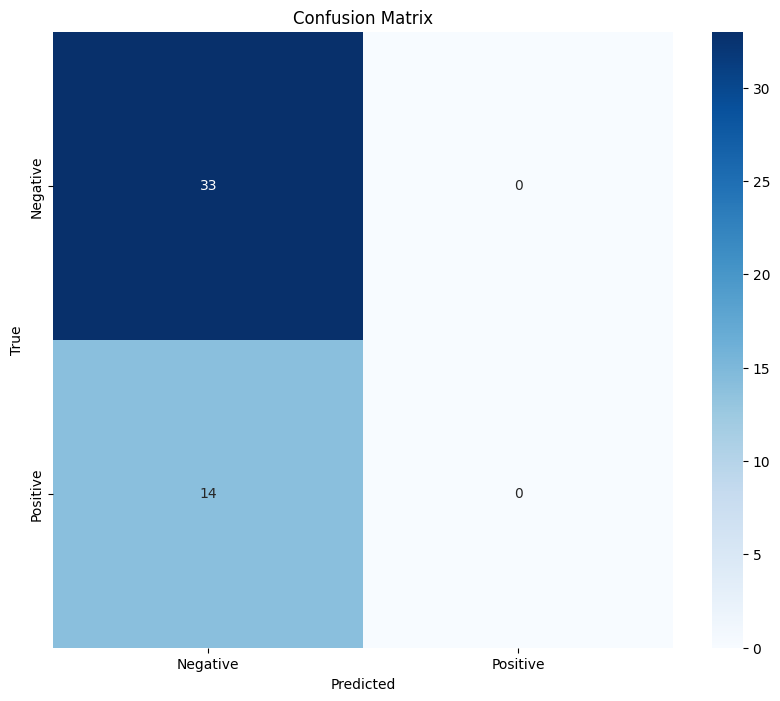

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Thresholding(model.modelPredict(X_test), 0.8)
# Generate the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Get the class labels (if you have them)
# Replace class_labels with your actual class labels as a list of strings
#class_labels = ['Class 0', 'Class 1', 'Class 2', ...]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Print classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        33
           1       0.00      0.00      0.00        14

    accuracy                           0.70        47
   macro avg       0.35      0.50      0.41        47
weighted avg       0.49      0.70      0.58        47



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
